# Term Project

## Kevin Han, kh38823

## Using the adult dataset: https://archive.ics.uci.edu/dataset/2/adult. Predicts whether income exceeds $50k per year based on variety of factors, such as education, age, workclass, race, sex, etc. 

My learning model is binary classification. I will be implementing a neural network. My current expectation of the results is that it would provide a pretty good prediction of the target variable that is whether or not any given adult exceeds $50k per year in income. However, since a neural network is a black box with many layers, it is practically impossible to evaluate which parameters/features are the best predictors of the target variables. This is only of the largest disadvantages to neural networks in my opinion. It is a powerful predictor but a very poor interpreter of the data.

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
from ucimlrepo import fetch_ucirepo
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = pd.DataFrame(adult.data.features)
y = pd.DataFrame(adult.data.targets)

# Clean up dataset and hot encode. Not sure why some values have a period and others do not, but I'm going to treat them as the same.
# Hot encode categorical target variable
y['income'] = y['income'].map({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})
print(X.columns)



Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')


In [131]:
# Look at categorical variables in X. Use LabelEncoder. 

# Look at which variables would be categorical in X
print(X.columns.tolist())

# Define the categorical variables
categorical_var = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a dictionary to store the mapping of the encoding for future reference
encoding_mapping = {}

# Loop through each categorical variable
for var in categorical_var:
    # Fit and transform the variable, and store the encoded values in X_encoded
    X[var] = label_encoder.fit_transform(X[var])
    
    # Store the mapping information in the dictionary
    encoding_mapping[var] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping information for each variable
for var, mapping in encoding_mapping.items():
    print(f"Mapping for '{var}': {mapping}")

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Mapping for 'workclass': {'?': 0, 'Federal-gov': 1, 'Local-gov': 2, 'Never-worked': 3, 'Private': 4, 'Self-emp-inc': 5, 'Self-emp-not-inc': 6, 'State-gov': 7, 'Without-pay': 8, nan: 9}
Mapping for 'education': {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}
Mapping for 'marital-status': {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
Mapping for 'occupation': {'?': 0, 'Adm-clerical': 1, 'Armed-Forces': 2, 'Craft-repair': 3, 'Exec-managerial': 4, 'Farming-fishing': 5, 'Handlers-cleaners': 6, 'Machine-op-inspct': 7, 'Ot

In [132]:
# Concatenate X and y for easy stratified sampling
data_df = pd.DataFrame(X, columns=adult.data.feature_names)
data_df['income'] = y

# Drop question marks
data_df = data_df[(data_df['workclass'] != 0) & (data_df['occupation'] != 0)]

In [133]:
print(data_df['income'].value_counts())

0    35503
1    11496
Name: income, dtype: int64


In [134]:
# To prevent skewing the dataset, I want equal samples of both <=50K and >50K incomes in both my training and testing datasets

# Split the dataset based on 'income' column
income_0_df = data_df[data_df['income'] == 0]
income_1_df = data_df[data_df['income'] == 1]

# Randomly sample 1600 instances from each income group for training data
sub50k_training = income_0_df.sample(n=1600, random_state=123)
over50k_training = income_1_df.sample(n=1600, random_state=123)

# Subtract the already sampled instances from main dataframe
remaining_data_df = data_df.drop(index=sub50k_training.index)
remaining_data_df = remaining_data_df.drop(index=over50k_training.index)
remaining_income_0 = remaining_data_df[remaining_data_df['income'] == 0]
remaining_income_1 = remaining_data_df[remaining_data_df['income'] == 1]

# Randomly sample 400 instances for testing data
sub50k_testing = remaining_income_0.sample(n=400, random_state=123)
over50k_testing = remaining_income_1.sample(n=400, random_state=123)

# Define the training and testing datasets
combined_training_df = pd.concat([sub50k_training, over50k_training], ignore_index=True)
X_train = combined_training_df.drop('income', axis=1)
y_train = combined_training_df['income']

combined_testing_df = pd.concat([sub50k_testing, over50k_testing], ignore_index=True)
X_test = combined_testing_df.drop('income', axis=1)
y_test = combined_testing_df['income']

In [135]:
print(y_train.value_counts())
print(y_test.value_counts())

0    1600
1    1600
Name: income, dtype: int64
0    400
1    400
Name: income, dtype: int64


In [136]:
# Now that we have sampled well and defined the training and testing data, let's preprocess our data for the neural network
# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# Normalize the input features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train.numpy())
X_train = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_normalized = scaler.fit_transform(X_test.numpy())
X_test = torch.tensor(X_test_normalized, dtype=torch.float32)

In [137]:
# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input layer to hidden layer
        self.fc2 = nn.Linear(64, 32)          # Hidden layer to hidden layer
        self.fc3 = nn.Linear(32, 1)           # Hidden layer to output layer
        self.relu = nn.LeakyReLU(0.01)            # LeakyReLU activation function. Introduce non-linearity in order to learn a more complex relationship. Used Leaky to acount for negatives.
        self.sigmoid = nn.Sigmoid()           # Sigmoid activation function, required for binary classification
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [138]:
# Initialize the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Hyper-parameters
weight_decay = 0.001 # For L2 regularization
num_epochs = 100 # Number of iterations
lr = 0.01 # Learning rate
batch_size = 32 # batch size for mini-batch gradient descent 
alpha = 1.1  # Bold driver parameter for increasing LR
beta = 0.5   # Bold driver parameter for decreasing LR


# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Adam optimizer

# Initialize the previous loss for comparison
prev_loss = float('inf')

# Initialize the initial learning rate
initial_lr = optimizer.param_groups[0]['lr']

# Create DataLoader for batched data
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize loss list for visualization
losses = []

print(model)

NeuralNetwork(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)


In [139]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate over batches
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Add L2 regularization to the loss
        l2_reg = 0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
        loss += weight_decay * l2_reg 

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    # Print training loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Update learning rate based on loss change
    if epoch_loss > prev_loss:
        # Increase learning rate
        optimizer.param_groups[0]['lr'] *= alpha
    else:
        # Decrease learning rate
        optimizer.param_groups[0]['lr'] *= beta

     # Update previous loss for the next epoch
    prev_loss = epoch_loss


Epoch [10/100], Loss: 0.4041
Epoch [20/100], Loss: 0.4039
Epoch [30/100], Loss: 0.4039
Epoch [40/100], Loss: 0.4039
Epoch [50/100], Loss: 0.4039
Epoch [60/100], Loss: 0.4039
Epoch [70/100], Loss: 0.4039
Epoch [80/100], Loss: 0.4039
Epoch [90/100], Loss: 0.4039
Epoch [100/100], Loss: 0.4039


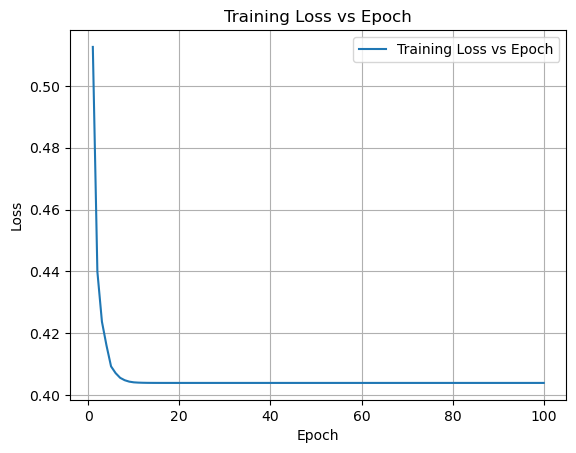

In [140]:
# Plot epoch vs loss
plt.plot(range(1, num_epochs+1), losses, label='Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)

In [141]:
# Evaluation on test set
with torch.no_grad():
    model.eval()
    val_outputs = model(X_test)
    val_outputs_cls = (val_outputs >= 0.5).float()
    val_accuracy = (val_outputs_cls == y_test).float().mean()
    print(f'Test Accuracy: {val_accuracy.item()*100:.2f}%')
    # Convert predicted outputs to binary predictions (0 or 1)
    val_predictions = (val_outputs >= 0.5).float()

    # True positives, false positives, true negatives, false negatives
    TP = ((val_predictions == 1) & (y_test == 1)).sum().item()
    FP = ((val_predictions == 1) & (y_test == 0)).sum().item()
    TN = ((val_predictions == 0) & (y_test == 0)).sum().item()
    FN = ((val_predictions == 0) & (y_test == 1)).sum().item()

    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP + 1e-10)  # Add small epsilon to avoid division by zero
    recall = TP / (TP + FN + 1e-10)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid division by zero
    specificity = TN / (TN + FP)

    # Print the evaluation metrics
    print(f'True Positives: {TP}')
    print(f'False Positives: {FP}')
    print(f'True Negatives: {TN}')
    print(f'False Negatives: {FN}')
    print(f'Precision: {precision:.4f}')
    print(f'Specificty: {specificity:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')

Test Accuracy: 81.50%
True Positives: 339
False Positives: 87
True Negatives: 313
False Negatives: 61
Precision: 0.7958
Specificty: 0.7825
Recall: 0.8475
F1 Score: 0.8208


# Interpretation

It seems that my neural network did pretty well! I implemented a wide variety of techniques learned in this class in the gradient descent algorithm for the backpropogation process, such as the bold driver, L2 regularization, stochastic GD(Adam), as well as minibatch gradient descent. I found that adding these techniques led to a higher accuracy score as well as a very fast convergence.

I predicted 81.5% of my samples correctly, with no clear bias towards positive or negative predictions. I predicted 79.6% of actual positive predictions correctly, 78.3% of actual negative predictions correctly, and 84.75% of overall positives correctly. These are pretty satisfactory results given the conditions.


 Something that could be helpful in the future to improve my results is to implement cross validation as well to fine-tune my hyperparameters, as well as using a larger dataset. A very large-scale version of this project could include loops across cross-validations where I perform a linear regression connecting my hyperparameters to my accuracy score! However, this is extremely extremely expensive and time consuming, so I'm happy with just having an operational neural network for now. 

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

LRmodel = LogisticRegression( fit_intercept=True)
LRmodel.fit(X_train, y_train)
LRpred = LRmodel.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, LRpred)))
print(classification_report(y_test, LRpred))

Accuracy score: 0.74875
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       400
         1.0       0.76      0.73      0.75       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



/Users/kevinhan/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


It should be noted that logistic regression works like a neural network, just as a very rudimentary one with one layer that is the sigmoid activation function. We can see that adding the extra layers as we did to form a bigger neural network improved prediction metrics all across the board when compared to just using Logistic Regression.

In [144]:
from sklearn import svm
SVMmodel = svm.SVC()
SVMmodel.fit(X_train, y_train)


SVMpred = SVMmodel.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, SVMpred))
print(classification_report(y_test, SVMpred))

/Users/kevinhan/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.80875
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80       400
         1.0       0.78      0.87      0.82       400

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



SVM comes close, but still a bit worse.

In [157]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train, y_train)

KNNpred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, KNNpred)
print("Accuracy:", accuracy)

Accuracy: 0.78


/Users/kevinhan/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN did not perform as well, but slightly better than logistic regression.

In [158]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
TREEpred = tree_clf.predict(X_test)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, TREEpred)
print("Accuracy:", accuracy_tree)

Accuracy: 0.75125


Decision trees did not perform as well. Pretty much the same as logistic regression.

In [159]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize the AdaBoost Classifier
adaboost_clf = AdaBoostClassifier()

# Fit the classifier to the training data
adaboost_clf.fit(X_train, y_train)

# Predict on the test data
Y_pred_adaboost = adaboost_clf.predict(X_test)

# Calculate accuracy
accuracy_adaboost = accuracy_score(y_test, Y_pred_adaboost)
print("AdaBoost Classifier Accuracy:", accuracy_adaboost)

/Users/kevinhan/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost Classifier Accuracy: 0.81


Wow! Very close! Even with an ensemble method like AdaBoost, it still is slightly below the accuracy I reached with my neural network. Furthermore, I would argue that there is no increase in interpretability in AdaBoost when compared to neural networks. Thus, even with the avengers of classic classifiers, it still couldn't surpass my neural network. 